In [1]:
import os, shutil
from keras import Input
from keras import Model
from keras import models
from keras import layers
from keras import losses
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
import importlib as im
import cnn_utilities as cn
import tensorflow as tf
from sklearn import metrics


Using TensorFlow backend.


In [3]:
full_data = pd.read_csv("data_files/extant_training_set_0to40.cblv.csv", 
                   header =None, error_bad_lines = False, index_col = 0).to_numpy()

full_labels = pd.read_csv("data_files/extant_training_set_0to40_labels.csv",
                    header = None, error_bad_lines = False).to_numpy()



ERROR! Session/line number was not unique in database. History logging moved to new session 3160


In [4]:
# randomize data order
randomized_idx = np.random.permutation(full_data.shape[0])
full_data = full_data[randomized_idx,:]
full_labels = full_labels[randomized_idx,:]
full_data.shape



(111157, 3514)

In [5]:
# setting up the data shape params and aux params
num_locs = 5
max_tips = 502
num_test = 1000 
num_validation = 2000  # found early stoping epoch number using 10000 validation
num_sample = full_data.shape[0]

num_tips = cn.get_num_tips(full_data)
subsample_prop = full_data[:,(max_tips-1) * 7]
mu = full_data[:,(max_tips - 3) * 7]


In [6]:
# make labels
labels = full_labels[0:num_sample, 0:5]
train_labels = labels[(num_test + num_validation):,:]
validation_labels = labels[num_test:num_test + num_validation,]
test_labels = labels[:num_test,]

In [7]:
# set up auxilliary priors and normalize; tree statistics and prior known parameter values (or ranges) 
# get num_tips and normalize
aux_priors_treestats = np.vstack((mu, subsample_prop, num_tips, 
                                  full_labels[0:num_sample,8], 
                                  full_labels[0:num_sample,9])).transpose()
norm_train_aux_priors_treestats, train_aux_priors_means, train_aux_priors_sd = cn.normalize(aux_priors_treestats[num_test + num_validation:,:])

norm_val_aux_priors_treestats = cn.normalize(aux_priors_treestats[num_test:num_test + num_validation,], 
                                            (train_aux_priors_means, train_aux_priors_sd))
norm_test_aux_priors_treestats = cn.normalize(aux_priors_treestats[:num_test,], 
                                            (train_aux_priors_means, train_aux_priors_sd))

norm_aux_priors_treestats = np.concatenate((norm_test_aux_priors_treestats, 
                                            norm_val_aux_priors_treestats, 
                                            norm_train_aux_priors_treestats))


In [8]:
# dev create data tensors
        
full_treeLocation_tensor, full_prior_tensor = cn.create_data_tensors(data = full_data[0:num_sample,:], 
                                                                        mu = norm_aux_priors_treestats[:,0],
                                                                        subsample_prop = norm_aux_priors_treestats[:,1],
                                                                        num_tips = norm_aux_priors_treestats[:,2],
                                                                        tmrca = norm_aux_priors_treestats[:,3],
                                                                        mean_bl = norm_aux_priors_treestats[:,4],
                                                                        num_locs = num_locs,
                                                                        max_tips = max_tips,
                                                                        cblv_contains_mu_rho = True)

train_treeLocation_tensor, validation_treeLocation_tensor,  test_treeLocation_tensor = cn.create_train_val_test_tensors(full_treeLocation_tensor, 
                                                                                                                        num_validation, num_test)
train_prior_tensor, validation_prior_tensor,  test_prior_tensor = cn.create_train_val_test_tensors(full_prior_tensor, 
                                                                                                   num_validation, num_test)

print(train_treeLocation_tensor.shape, train_prior_tensor.shape)
print(test_treeLocation_tensor.shape, test_prior_tensor.shape)
print(validation_treeLocation_tensor.shape, validation_prior_tensor.shape)

(108157, 499, 7) (108157, 5, 2)
(1000, 499, 7) (1000, 5, 2)
(2000, 499, 7) (2000, 5, 2)


In [9]:
im.reload(cn)

<module 'cnn_utilities' from 'C:\\Users\\ammon_work\\Desktop\\git_repos\\epi_geo_simulation\\neural_network_dev\\cnn_utilities.py'>

In [16]:
# multi input cnn
input_treeLocation_tensor = Input(shape = train_treeLocation_tensor.shape[1:3])
w1 = layers.Conv1D(64, 3, strides = 1, activation = 'relu', padding = 'same')(input_treeLocation_tensor)
w = layers.Conv1D(64, 5, activation = 'relu', padding = 'same')(w1)
#w = layers.MaxPooling1D(pool_size = 3, stride = 1)(w)
w = layers.Conv1D(96, 5, activation = 'relu', padding = 'same')(w)
w = layers.Conv1D(128, 5, activation = 'relu', padding = 'same')(w)
w = layers.Conv1D(256, 7, activation = 'relu', padding = 'same')(w)
w_global_avg = layers.GlobalAveragePooling1D(name = 'w')(w)

w_stride = layers.Conv1D(64, 7, strides = 3, activation = 'relu', padding = 'same')(w1)
w_stride = layers.Conv1D(96, 9, strides = 6, activation = 'relu', padding = 'same')(w_stride)
w_stride_global_avg = layers.GlobalAveragePooling1D(name = 'w_stride_global_avg')(w_stride)

# tree + geolocation dilated
w_dilated = layers.Conv1D(32, 3, dilation_rate = 2, activation = 'relu', padding = "same")(w1)
w_dilated = layers.Conv1D(64, 5, dilation_rate = 4, activation = 'relu', padding = "same")(w_dilated)
w_dilated = layers.Conv1D(128, 7, dilation_rate = 8, activation = 'relu', padding = "same")(w_dilated)
w_dilated_global_avg = layers.GlobalAveragePooling1D(name = 'w_dilated_global_avg')(w_dilated)

# prior known parameters and data statistics
input_priors_tensor = Input(shape = train_prior_tensor.shape[1:3])
priors = layers.Flatten()(input_priors_tensor)
priors = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling', name = 'prior1')(priors)

# concatenate all above -> deep fully connected network
concatenated_wxyz = layers.Concatenate(axis = 1, name = 'all_concatenated')([w_stride_global_avg,
                                                                             w_global_avg,
                                                                             w_dilated_global_avg,
                                                                             priors])

wxyz = layers.Dense(256, activation = 'relu', kernel_initializer = 'VarianceScaling')(concatenated_wxyz)
wxyz = layers.Dense(128, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
wxyz = layers.Dense(64, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)
wxyz = layers.Dense(32, activation = 'relu', kernel_initializer = 'VarianceScaling')(wxyz)


output_root_loc_layers = layers.Dense(5, activation = 'softmax', name = 'root_loc_output')(wxyz)



Train on 108157 samples, validate on 2000 samples
Epoch 1/10
108157/108157 [==============================] - 219s 2ms/step - loss: 0.7998 - acc: 0.7416 - auc_2: 0.8596 - categorical_crossentropy: 0.9929 - val_loss: 0.6963 - val_acc: 0.7875 - val_auc_2: 0.9164 - val_categorical_crossentropy: 0.7986
Epoch 2/10
108157/108157 [==============================] - 219s 2ms/step - loss: 0.6658 - acc: 0.7987 - auc_2: 0.9230 - categorical_crossentropy: 0.7591 - val_loss: 0.7011 - val_acc: 0.7870 - val_auc_2: 0.9273 - val_categorical_crossentropy: 0.7322
Epoch 3/10
108157/108157 [==============================] - 219s 2ms/step - loss: 0.6485 - acc: 0.8032 - auc_2: 0.9298 - categorical_crossentropy: 0.7169 - val_loss: 0.6549 - val_acc: 0.8010 - val_auc_2: 0.9318 - val_categorical_crossentropy: 0.7044
Epoch 4/10
108157/108157 [==============================] - 219s 2ms/step - loss: 0.6358 - acc: 0.8073 - auc_2: 0.9334 - categorical_crossentropy: 0.6952 - val_loss: 0.6648 - val_acc: 0.7985 - val_auc

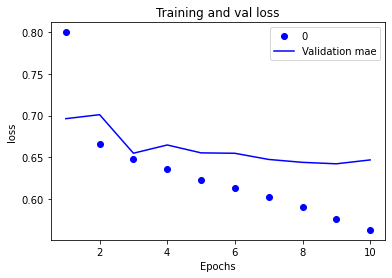

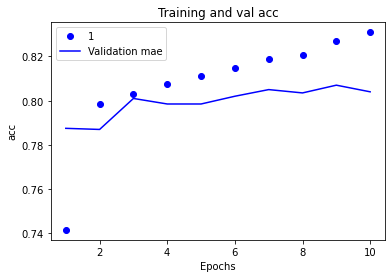

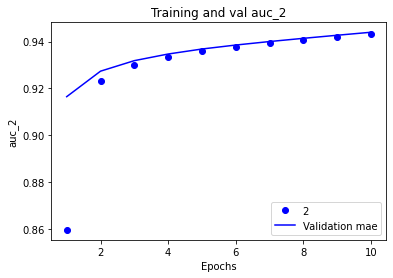

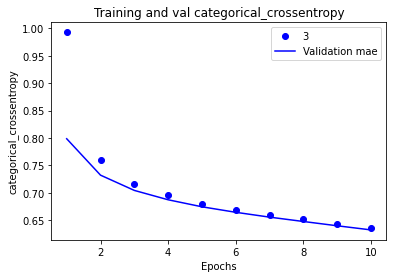

1000/1000 [==============================] - 1s 1ms/step


[0.7214768300056458, 0.7799999713897705, 0.9439368844032288, 0.632399320602417]

In [17]:
# POWER MSE
# def myLoss(y_true, y_pred):
#     power = 2
#     power_loss = tf.math.abs(y_true - y_pred)**power
#     return tf.reduce_mean(power_loss, axis=-1)

myLoss = "categorical_crossentropy"

# NOTE: 'sparse_categorical_crossentropy' doesn't require one-hot encoding.  Consider for future...

# instantiate MODEL
mymodel = Model(inputs = [input_treeLocation_tensor, input_priors_tensor], 
                outputs = output_root_loc_layers)
mymodel.compile(optimizer = 'adam', 
                loss = myLoss, 
                metrics = ['acc', tf.keras.metrics.AUC(), tf.keras.metrics.CategoricalCrossentropy()])

history = mymodel.fit([train_treeLocation_tensor, train_prior_tensor], 
                      train_labels,
                    epochs = 10, batch_size = 128, 
                    validation_data = ([validation_treeLocation_tensor, validation_prior_tensor], 
                                       validation_labels))


# make history plots
cn.make_history_plot(history)

mymodel.evaluate([test_treeLocation_tensor, test_prior_tensor], test_labels)

In [18]:
##################33
## TEST loc pred ###
###################
test_preds = mymodel.predict([test_treeLocation_tensor, test_prior_tensor])
nt_nv = num_test + num_validation
test_pred_labels = test_labels[:, 0:5]


In [19]:
# how predictive are just counts without any phylo info?
tip_loc_counts = np.zeros((test_treeLocation_tensor.shape[0],num_locs))
tip_loc_distro = np.zeros((test_treeLocation_tensor.shape[0],num_locs))
accuracy_tipfreq = np.zeros((test_treeLocation_tensor.shape[0]))
accuracy_pred = np.zeros((test_treeLocation_tensor.shape[0]))
acc_top_pred = np.zeros((test_treeLocation_tensor.shape[0]))
acc_top_tipfreq = np.zeros((test_treeLocation_tensor.shape[0]))

for i in range(0, test_treeLocation_tensor.shape[0]):    
    tip_loc_counts[i,:] = sum(test_treeLocation_tensor[i,:,2:2+num_locs])
    tip_loc_distro[i,:] = tip_loc_counts[i,:] / sum(tip_loc_counts[i,:])
    accuracy_tipfreq[i] = sum(tip_loc_distro[i,:] * test_labels[i,:])
    accuracy_pred[i] = sum(test_preds[i,:] * test_labels[i,:])
    acc_top_tipfreq[i] = 1 * (np.argmax(tip_loc_distro[i,:]) == np.argmax(test_labels[i,:]))
    acc_top_pred[i] = 1 * (np.argmax(test_preds[i,:]) == np.argmax(test_labels[i,:]))

print("tip frequency accuracy: ", np.mean(accuracy_tipfreq))
print("cnn prediction accuracy: ", np.mean(accuracy_pred))
print("top tip prediction accuracy: ", np.mean(acc_top_tipfreq))
print("top cnn prediction accuracy: ", np.mean(acc_top_pred))

 

tip frequency accuracy:  0.49103005801569566
cnn prediction accuracy:  0.6907151683708653
top tip prediction accuracy:  0.752
top cnn prediction accuracy:  0.78


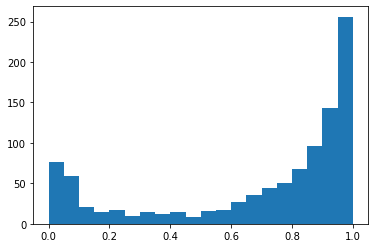

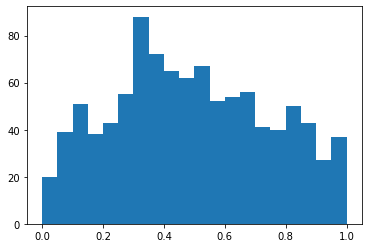

In [20]:
test_accuracy = np.max(test_preds * test_labels, axis = 1)
plt.hist(test_accuracy, bins = 20, range = [0,1])
plt.show()
plt.hist(accuracy_tipfreq, bins = 20, range = [0,1])
plt.show()

In [21]:
import csv
mymodel.save("saved_models/train_extant_root_location.hdf5")
# mymodel.save("saved_models/train_largerRange_128batch_10epoch_root_location.hdf5")
